# **Tahap 1 – Membangun Case Base**

### Seleksi & Unduh

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas requests beautifulsoup4 pdfminer.six lxml > /dev/null 2>&1

In [3]:
import argparse
import io
import os
import re
import time
import urllib
from concurrent.futures import ThreadPoolExecutor, wait
from datetime import date
import pandas as pd
import requests
from bs4 import BeautifulSoup
from pdfminer.high_level import extract_text

In [4]:
def create_path(folder_name):
    path = os.path.join(os.getcwd(), folder_name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def open_page(link):
    count = 0
    while count < 3:
        try:
            return BeautifulSoup(requests.get(link).text, "lxml")
        except:
            count += 1
            time.sleep(5)


def get_detail(soup, keyword):
    try:
        text = (
            soup.find(lambda tag: tag.name == "td" and keyword in tag.text)
            .find_next()
            .get_text()
            .strip()
        )
        return text
    except:
        return ""


def get_pdf(url, path_pdf):
    try:
        file = urllib.request.urlopen(url)
        file_name = os.path.basename(url)
        file_content = file.read()
        with open(f"{path_pdf}/{file_name}", "wb") as out_file:
            out_file.write(file_content)
        return io.BytesIO(file_content), file_name
    except:
        return None, None


def clean_text(text):
    text = text.replace("M a h ka m a h A g u n g R e p u blik In d o n esia\n", "")
    text = text.replace("Disclaimer\n", "")
    text = text.replace(
        "Kepaniteraan Mahkamah Agung Republik Indonesia berusaha untuk selalu mencantumkan informasi paling kini dan akurat sebagai bentuk komitmen Mahkamah Agung untuk pelayanan publik, transparansi dan akuntabilitas\n",
        "",
    )
    text = text.replace(
        "pelaksanaan fungsi peradilan. Namun dalam hal-hal tertentu masih dimungkinkan terjadi permasalahan teknis terkait dengan akurasi dan keterkinian informasi yang kami sajikan, hal mana akan terus kami perbaiki dari waktu kewaktu.\n",
        "",
    )
    text = text.replace(
        "Dalam hal Anda menemukan inakurasi informasi yang termuat pada situs ini atau informasi yang seharusnya ada, namun belum tersedia, maka harap segera hubungi Kepaniteraan Mahkamah Agung RI melalui :\n",
        "",
    )
    text = text.replace(
        "Email : kepaniteraan@mahkamahagung.go.id    Telp : 021-384 3348 (ext.318)\n",
        "",
    )
    return text


def extract_data(link, keyword_url, path_output, path_pdf, today):
    soup = open_page(link)
    table = soup.find("table", {"class": "table"})
    judul = table.find("h2").text if table.find("h2") else ""

    nomor = get_detail(table, "Nomor")
    tingkat_proses = get_detail(table, "Tingkat Proses")
    klasifikasi = get_detail(table, "Klasifikasi")
    kata_kunci = get_detail(table, "Kata Kunci")
    tahun = get_detail(table, "Tahun")
    tanggal_register = get_detail(table, "Tanggal Register")
    lembaga_peradilan = get_detail(table, "Lembaga Peradilan")
    jenis_lembaga_peradilan = get_detail(table, "Jenis Lembaga Peradilan")
    hakim_ketua = get_detail(table, "Hakim Ketua")
    hakim_anggota = get_detail(table, "Hakim Anggota")
    panitera = get_detail(table, "Panitera")
    amar = get_detail(table, "Amar")
    amar_lainnya = get_detail(table, "Amar Lainnya")
    catatan_amar = get_detail(table, "Catatan Amar")
    tanggal_musyawarah = get_detail(table, "Tanggal Musyawarah")
    tanggal_dibacakan = get_detail(table, "Tanggal Dibacakan")
    kaidah = get_detail(table, "Kaidah")
    status = get_detail(table, "Status")
    abstrak = get_detail(table, "Abstrak")

    try:
        link_pdf = soup.find("a", href=re.compile(r"/pdf/"))["href"]
        file_pdf, file_name_pdf = get_pdf(link_pdf, path_pdf)
        text_pdf = extract_text(file_pdf)
        text_pdf = clean_text(text_pdf)
    except:
        link_pdf = ""
        text_pdf = ""
        file_name_pdf = ""

    data = [
        judul,
        nomor,
        tingkat_proses,
        klasifikasi,
        kata_kunci,
        tahun,
        tanggal_register,
        lembaga_peradilan,
        jenis_lembaga_peradilan,
        hakim_ketua,
        hakim_anggota,
        panitera,
        amar,
        amar_lainnya,
        catatan_amar,
        tanggal_musyawarah,
        tanggal_dibacakan,
        kaidah,
        status,
        abstrak,
        link,
        link_pdf,
        file_name_pdf,
        text_pdf,
    ]
    result = pd.DataFrame(
        [data],
        columns=[
            "judul",
            "nomor",
            "tingkat_proses",
            "klasifikasi",
            "kata_kunci",
            "tahun",
            "tanggal_register",
            "lembaga_peradilan",
            "jenis_lembaga_peradilan",
            "hakim_ketua",
            "hakim_anggota",
            "panitera",
            "amar",
            "amar_lainnya",
            "catatan_amar",
            "tanggal_musyawarah",
            "tanggal_dibacakan",
            "kaidah",
            "status",
            "abstrak",
            "link",
            "link_pdf",
            "file_name_pdf",
            "text_pdf",
        ],
    )

    keyword_url = keyword_url.replace("/", " ")
    if keyword_url.startswith("https"):
        keyword_url = ""
    destination = f"{path_output}/putusan_ma_{keyword_url}_{today}"
    if not os.path.isfile(f"{destination}.csv"):
        result.to_csv(f"{destination}.csv", header=True, index=False)
    else:
        result.to_csv(f"{destination}.csv", mode="a", header=False, index=False)


def run_process(keyword_url, page, sort_date, path_output, path_pdf, today):
    if keyword_url.startswith("https"):
        link = f"{keyword_url}&page={page}"
    else:
        link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword_url}&page={page}"
    if sort_date:
        link = f"{link}&obf=TANGGAL_PUTUS&obm=desc"

    soup = open_page(link)
    links = soup.find_all("a", {"href": re.compile("/direktori/putusan")})

    for link in links:
        extract_data(link["href"], keyword_url, path_output, path_pdf, today)


def run_scraper(keyword=None, url=None, sort_date=True, download_pdf=True):
    if not keyword and not url:
        print("Please provide a keyword or URL")
        return

    path_output = '/content/drive/MyDrive/Penalaran Komputer3/CSV'
    path_pdf = '/content/drive/MyDrive/Penalaran Komputer3/PDF'
    today = date.today().strftime("%Y-%m-%d")

    link = f"https://putusan3.mahkamahagung.go.id/search.html?q={keyword}&page=1"
    if url:
        link = url

    soup = open_page(link)
    last_page = int(soup.find_all("a", {"class": "page-link"})[-1].get("data-ci-pagination-page"))

    if url:
        print(f"Scraping with url: {url} - {20 * last_page} data - {last_page} page")
    else:
        print(f"Scraping with keyword: {keyword} - {20 * last_page} data - {last_page} page")

    if url:
        keyword_url = url
    else:
        keyword_url = keyword

    futures = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        for page in range(last_page):
            futures.append(
                executor.submit(run_process, keyword_url, page + 1, sort_date, path_output, path_pdf, today)
            )
    wait(futures)


In [5]:
# Download Pidana Klasifikasi Pidana Umum-Kejahatan Terhadap kesusilaan
run_scraper(url="https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&cat=75d2c54ea4cb6d96d9314955bb46ba07&jd=&tp=0&court=099731PN161+++++++++++++++++++++&t_put=&t_reg=&t_upl=&t_pr=")

Scraping with url: https://putusan3.mahkamahagung.go.id/search.html?q=&jenis_doc=putusan&cat=75d2c54ea4cb6d96d9314955bb46ba07&jd=&tp=0&court=099731PN161+++++++++++++++++++++&t_put=&t_reg=&t_upl=&t_pr= - 40 data - 2 page


### Konversi & Ekstraksi Teks

In [6]:
!pip install pdfminer.six

In [7]:
import os

pdf_folder = '/content/drive/MyDrive/Penalaran Komputer3/PDF'
output_folder = '/content/drive/MyDrive/Penalaran Komputer3/data/raw'

os.makedirs(output_folder, exist_ok=True)

In [8]:
from pdfminer.high_level import extract_text

def convert_pdf_to_txt(pdf_path, txt_path):
    try:
        text = extract_text(pdf_path)
        with open(txt_path, 'w', encoding='utf-8') as f:
            f.write(text)
        print(f'✅ Berhasil konversi: {txt_path}')
    except Exception as e:
        print(f'❌ Gagal konversi {pdf_path}: {e}')

In [9]:
for i, filename in enumerate(sorted(os.listdir(pdf_folder))):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder, filename)
        txt_filename = f'case_{i+1:03}.txt'
        txt_path = os.path.join(output_folder, txt_filename)
        convert_pdf_to_txt(pdf_path, txt_path)

✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_001.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_002.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_003.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_004.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_005.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_006.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_007.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_008.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_009.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_010.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran Komputer3/data/raw/case_011.txt
✅ Berhasil konversi: /content/drive/MyDrive/Penalaran 

### Pembersihan

In [10]:
import os
import re

# Fungsi pembersih
def bersihkan_teks(teks):
    teks = re.sub(r'putusan\.?mahkamahagung\.?go\.?id', '', teks, flags=re.IGNORECASE)
    teks = re.sub(r'disclaimer.*?kami sajikan.*?(?=\s|$)', '', teks, flags=re.IGNORECASE | re.DOTALL)
    teks = re.sub(r'kepaniteraan@mahkamahagung\.?go\.?id', '', teks, flags=re.IGNORECASE)
    teks = re.sub(r'telp.*?\d{3}.*?(?=\s|$)', '', teks, flags=re.IGNORECASE)
    teks = re.sub(r'\bhalaman\s*\d+\b', '', teks, flags=re.IGNORECASE)
    teks = re.sub(r'\bhalaman\b', '', teks, flags=re.IGNORECASE)
    teks = re.sub(r'\d+\s*dari\s*\d+\s*halaman', '', teks, flags=re.IGNORECASE)
    teks = re.sub(r'\s+', ' ', teks)
    teks = teks.lower().strip()
    return teks

# Folder input & output
input_folder = '/content/drive/MyDrive/Penalaran Komputer3/data/raw'
output_folder = '/content/drive/MyDrive/Penalaran Komputer3/data_clean/raw'
os.makedirs(output_folder, exist_ok=True)

# Loop semua file .txt
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.txt'):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        with open(input_path, 'r', encoding='utf-8') as f:
            teks = f.read()

        teks_bersih = bersihkan_teks(teks)

        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(teks_bersih)

        print(f"✅ Dibersihkan dan disimpan: {filename}")

✅ Dibersihkan dan disimpan: case_001.txt
✅ Dibersihkan dan disimpan: case_002.txt
✅ Dibersihkan dan disimpan: case_003.txt
✅ Dibersihkan dan disimpan: case_004.txt
✅ Dibersihkan dan disimpan: case_005.txt
✅ Dibersihkan dan disimpan: case_006.txt
✅ Dibersihkan dan disimpan: case_007.txt
✅ Dibersihkan dan disimpan: case_008.txt
✅ Dibersihkan dan disimpan: case_009.txt
✅ Dibersihkan dan disimpan: case_010.txt
✅ Dibersihkan dan disimpan: case_011.txt
✅ Dibersihkan dan disimpan: case_012.txt
✅ Dibersihkan dan disimpan: case_013.txt
✅ Dibersihkan dan disimpan: case_014.txt
✅ Dibersihkan dan disimpan: case_015.txt
✅ Dibersihkan dan disimpan: case_016.txt
✅ Dibersihkan dan disimpan: case_017.txt
✅ Dibersihkan dan disimpan: case_018.txt
✅ Dibersihkan dan disimpan: case_019.txt
✅ Dibersihkan dan disimpan: case_020.txt
✅ Dibersihkan dan disimpan: case_021.txt
✅ Dibersihkan dan disimpan: case_022.txt
✅ Dibersihkan dan disimpan: case_023.txt
✅ Dibersihkan dan disimpan: case_024.txt
✅ Dibersihkan da

### Validasi

In [11]:
import os
import re
from datetime import datetime

# Path folder
raw_folder = '/content/drive/MyDrive/Penalaran Komputer3/data/raw'
clean_folder = '/content/drive/MyDrive/Penalaran Komputer3/data_clean/raw'
log_path = '/content/drive/MyDrive/Penalaran Komputer3/logs/cleaning.log'

# Buat folder log jika belum ada
os.makedirs(os.path.dirname(log_path), exist_ok=True)

# Tulis log
with open(log_path, 'w', encoding='utf-8') as log_file:
    log_file.write(f"Log Validasi Pembersihan Teks\nWaktu: {datetime.now()}\n\n")
    log_file.write(f"{'File':<15} {'Original':<10} {'Cleaned':<10} {'Persen':<10} {'Status'}\n")
    log_file.write('-'*60 + '\n')

    for filename in sorted(os.listdir(raw_folder)):
        if filename.endswith('.txt'):
            raw_path = os.path.join(raw_folder, filename)
            clean_path = os.path.join(clean_folder, filename)

            try:
                with open(raw_path, 'r', encoding='utf-8') as f:
                    raw_text = f.read()
                with open(clean_path, 'r', encoding='utf-8') as f:
                    clean_text = f.read()

                raw_len = len(raw_text)
                clean_len = len(clean_text)
                percent = (clean_len / raw_len) * 100 if raw_len > 0 else 0

                status = "✅ OK" if percent >= 80 else "⚠️ Kurang"

                log_file.write(f"{filename:<15} {raw_len:<10} {clean_len:<10} {percent:<9.2f}% {status}\n")

            except Exception as e:
                log_file.write(f"{filename:<15} ERROR saat membaca: {e}\n")

In [12]:
import os

folder_path = '/content/drive/MyDrive/Penalaran Komputer3'  # ganti sesuai nama aslinya kalau beda

# Tampilkan semua file di dalam folder
for root, dirs, files in os.walk(folder_path):
    print(f"\n📁 Folder: {root}")
    for name in files:
        print(f"  📄 {name}")



📁 Folder: /content/drive/MyDrive/Penalaran Komputer3

📁 Folder: /content/drive/MyDrive/Penalaran Komputer3/PDF
  📄 b4e3f6c5823b3d91699a7103bb15ec48(1).pdf
  📄 aaba656bde3badd5441b3a072eed21f8(1).pdf
  📄 fdbd2c77c44361e14b5c7bcd071bd2cd(1).pdf
  📄 zaee1b0b445e2572a8c8313530393330(1).pdf
  📄 zaf0501287f819c6805e313631343536.pdf
  📄 zaeb2f72c64c26889e02303630353536.pdf
  📄 fefce1fd793dc6fe9f584adf11b174df(1).pdf
  📄 zaedb321b78d536c94a1303932383131.pdf
  📄 b4e3f6c5823b3d91699a7103bb15ec48.pdf
  📄 d4f8cea97a92c76c45a2cde0b18e818b(1).pdf
  📄 43d0fd42a03e68c890645a517b8645f0(1).pdf
  📄 25a0c33680cb5f0399e146fd3d75e1e4(1).pdf
  📄 zaef96b844754c0a9c6c313931323433(2).pdf
  📄 zaee1b0b445e2572a8c8313530393330.pdf
  📄 1fcb81b39bb9c204a76158bd07896566(1).pdf
  📄 zaf0501351515602ae19313632303334.html
  📄 zaedb3466065e43aa485313335303336(1).pdf
  📄 a96f026c707329d38385847dfa2f8cda(1).pdf
  📄 423d272e279b6004d35ca71d6858abd2(1).pdf
  📄 zaef96b844754c0a9c6c313931323433(1).pdf
  📄 c6d896388fd15930a4d4a

# **Tahap 2 – Case Representation**

### Ekstraksi Metadata

In [13]:
import os
import re
import pandas as pd

# Path input dan output
input_folder = '/content/drive/MyDrive/Penalaran Komputer3/data_clean/raw'
output_csv = '/content/drive/MyDrive/Penalaran Komputer3/data/processed/metadata_only.csv'
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

# Fungsi ekstraksi metadata
def extract_metadata(text):
    match_no = re.search(r'(nomor|no)[\s:]*([^\n;,]*)', text, re.IGNORECASE)
    no_perkara = match_no.group(2).strip() if match_no else ''

    match_tgl = re.search(r'(\d{1,2} [a-zA-Z]+ \d{4})', text)
    tanggal = match_tgl.group(1) if match_tgl else ''

    if 'pidana' in text.lower():
        jenis = 'Pidana'
    elif 'perdata' in text.lower():
        jenis = 'Perdata'
    else:
        jenis = ''

    pasal = re.findall(r'pasal[\s:]+(\d+[a-z]*)', text, re.IGNORECASE)
    pasal = ', '.join(sorted(set(pasal))) if pasal else ''

    pihak = ''
    match_pihak = re.search(r'antara\s+(.*?)\s+melawan\s+(.*?)[\.,\n]', text, re.IGNORECASE)
    if match_pihak:
        pihak = f"{match_pihak.group(1).strip()} vs. {match_pihak.group(2).strip()}"

    return no_perkara, tanggal, jenis, pasal, pihak

# Loop semua file dan simpan hasil
rows = []

for i, filename in enumerate(sorted(os.listdir(input_folder))):
    if filename.endswith('.txt'):
        file_path = os.path.join(input_folder, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        no_perkara, tanggal, jenis, pasal, pihak = extract_metadata(text)

        rows.append({
            'case_id': i + 1,
            'file_name': filename,
            'no_perkara': no_perkara,
            'tanggal': tanggal,
            'jenis_perkara': jenis,
            'pasal': pasal,
            'pihak': pihak,
            'text_full': text
        })

df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False)
print(f'✅ Metadata disimpan ke: {output_csv}')


✅ Metadata disimpan ke: /content/drive/MyDrive/Penalaran Komputer3/data/processed/metadata_only.csv


### Ekstraksi Konten Kunci

In [14]:
import pandas as pd
import re
import os

# Path input/output
input_csv = '/content/drive/MyDrive/Penalaran Komputer3/data/processed/metadata_only.csv'
output_csv = '/content/drive/MyDrive/Penalaran Komputer3/data/processed/cases.csv'
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

# Baca data
df = pd.read_csv(input_csv)

# Fungsi untuk ringkasan fakta
def extract_ringkasan_fakta(text):
    match = re.search(r'menimbang\s+bahwa\s+(.{50,1000}?)\.', text, re.IGNORECASE)
    if match:
        return match.group(1).strip()

    match = re.search(r'bahwa\s+(.{50,1000}?)\.', text, re.IGNORECASE)
    if match:
        return match.group(1).strip()

    return ''

# Fungsi untuk argumen hukum utama
def extract_argumen_hukum(text):
    match = re.search(r'memutuskan\s+(.{50,1000}?)\.', text, re.IGNORECASE)
    if match:
        return match.group(1).strip()

    match = re.search(r'dasarkan\s+pasal\s+(.{20,500}?)\.', text, re.IGNORECASE)
    if match:
        return match.group(1).strip()

    match = re.search(r'menyatakan\s+(.{50,1000}?)\.', text, re.IGNORECASE)
    if match:
        return match.group(1).strip()

    return ''

# Terapkan ke semua teks
df['ringkasan_fakta'] = df['text_full'].fillna('').apply(extract_ringkasan_fakta)
df['argumen_hukum'] = df['text_full'].fillna('').apply(extract_argumen_hukum)

# Simpan ke file output final
df.to_csv(output_csv, index=False)
print(f'✅ Ekstraksi konten kunci selesai. Disimpan ke:\n{output_csv}')

✅ Ekstraksi konten kunci selesai. Disimpan ke:
/content/drive/MyDrive/Penalaran Komputer3/data/processed/cases.csv


In [15]:
print("Contoh Ringkasan Fakta:")
print(df['ringkasan_fakta'].dropna().head())

print("\nContoh Argumen Hukum:")
print(df['argumen_hukum'].dropna().head())


Contoh Ringkasan Fakta:
0    terdakwa diajukan ke persidangan oleh penuntut...
1    terdakwa diajukan ke persidangan oleh penuntut...
2    putusan pengadilan tinggi medan tersebut telah...
3    putusan pengadilan tinggi medan tersebut telah...
4    putusan pengadilan tinggi banda aceh tersebut ...
Name: ringkasan_fakta, dtype: object

Contoh Argumen Hukum:
0    : 1. menyatakan terdakwa aris dwi saputro alia...
1    : 1. menyatakan terdakwa aris dwi saputro alia...
2    terdakwa tanajudin terbukti secara sah dan mey...
3    terdakwa tanajudin terbukti secara sah dan mey...
4    terdakwa muhammad syahar bin syarifuddin usman...
Name: argumen_hukum, dtype: object


### Feature Engineering

In [16]:
import pandas as pd
import re
import os

# Path input/output
input_csv = '/content/drive/MyDrive/Penalaran Komputer3/data/processed/cases.csv'
output_csv = '/content/drive/MyDrive/Penalaran Komputer3/data/processed/cases_features.csv'
os.makedirs(os.path.dirname(output_csv), exist_ok=True)

# Baca data
df = pd.read_csv(input_csv)

# Fitur 1: Panjang teks (jumlah kata)
df['length'] = df['text_full'].fillna('').apply(lambda x: len(x.split()))

# Fitur 2: Bag-of-Words Keywords (manual keyword list)
keywords = ['wanprestasi', 'gugatan', 'penggugat', 'tergugat', 'putusan', 'perjanjian', 'pidana', 'narkotika', 'cerai']
def extract_keywords(text):
    text = text.lower()
    found = [kw for kw in keywords if kw in text]
    return ', '.join(found)
df['bow_keywords'] = df['text_full'].fillna('').apply(extract_keywords)

# Fitur 3: Estimasi QA-pairs
def count_qa_pairs(text):
    patterns = r'\b(apa|siapa|mengapa|bagaimana|karena|maka|oleh karena)\b'
    return len(re.findall(patterns, text.lower()))
df['qa_pairs_count'] = df['text_full'].fillna('').apply(count_qa_pairs)

# Simpan ke file baru
df.to_csv(output_csv, index=False)
print(f'✅ Feature Engineering selesai.\nDisimpan ke: {output_csv}')

✅ Feature Engineering selesai.
Disimpan ke: /content/drive/MyDrive/Penalaran Komputer3/data/processed/cases_features.csv


# Tahap 3 – Case Retrieval

## Representasi Vektor

In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['quary_taxt'].astype(str))

# BERT Embedding
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
corpus = df['ringkasan_fakta'].astype(str).tolist()
corpus_embeddings = bert_model.encode(corpus, convert_to_tensor=True)

## Splitting Data

In [18]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
if not df.empty:
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    print("✅ Data berhasil dibagi:")
    print(f"Train: {len(train_data)} | Test: {len(test_data)}")
else:
    print("❗ DataFrame kosong. Pastikan proses sebelumnya berhasil.")


✅ Data berhasil dibagi:
Train: 67 | Test: 17


## Model Retrieval

### TF-IDF + SVM

In [20]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(tfidf_matrix, df['case_id'].astype(str))

LinearSVC()

## Fungsi Retrieval

### TF-IDF + SVM

In [21]:
def retrieve_svm(query: str):
    query_vec = vectorizer.transform([query])
    pred = svm_model.predict(query_vec)
    return pred[0]

### BERT

In [22]:
from sentence_transformers import util

def retrieve_bert(query: str, k: int = 5):
    query_embedding = bert_model.encode(query, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_k_idx = similarities.argsort(descending=True)[:k]
    return df.iloc[top_k_idx][['case_id', 'ringkasan_fakta']].to_dict(orient='records')

## Pengujian Awal

In [23]:
df[['case_id', 'ringkasan_fakta']].head(10)


,case_id,ringkasan_fakta
0,1,terdakwa diajukan ke persidangan oleh penuntut...
1,2,terdakwa diajukan ke persidangan oleh penuntut...
2,3,putusan pengadilan tinggi medan tersebut telah...
3,4,putusan pengadilan tinggi medan tersebut telah...
4,5,putusan pengadilan tinggi banda aceh tersebut ...
5,6,putusan pengadilan tinggi banda aceh tersebut ...
6,7,putusan pengadilan tinggi riau tersebut telah ...
7,8,putusan pengadilan tinggi riau tersebut telah ...
8,9,terdakwa diajukan ke persidangan oleh penuntut...
9,10,terdakwa diajukan ke persidangan oleh penuntut...


In [26]:
import os

folder_path = '/content/drive/MyDrive/Penalaran Komputer3/data/corpus/'
os.makedirs(folder_path, exist_ok=True)


In [108]:
import json

test_queries = []

base_queries = [
    ("terdakwa melakukan tindak pidana pencabulan terhadap anak di bawah umur", "1"),
    ("majlis hakim mempertimbangkan alat bukti berupa visum et repertum", "2"),
    ("putusan menyatakan terdakwa terbukti melanggar pasal 285 KUHP", "3"),
    ("hakim menjatuhkan pidana penjara selama 5 tahun kepada terdakwa", "4"),
    ("korban merupakan siswi sekolah yang masih berusia 14 tahun", "5"),
    ("terdakwa dijatuhi pidana karena menyetubuhi anak di bawah umur secara paksa", "6"),
    ("pengadilan menyatakan bahwa terdakwa melanggar kesusilaan terhadap korban", "7"),
    ("putusan menyatakan terdakwa bersalah atas tindak pidana persetubuhan anak", "8"),
    ("hakim mempertimbangkan bukti rekaman CCTV yang menunjukkan tindakan asusila", "9"),
    ("terdakwa menyentuh tubuh korban tanpa persetujuan, yang dinilai melanggar norma kesusilaan", "10"),
]

for i in range(100):
    text, truth = base_queries[i % 10]
    mod_text = f"{text} (variasi {i+1})"
    test_queries.append({
        "query_id": str(i+1),
        "query_text": mod_text,
        "ground_truth": truth
    })

# Simpan sebagai JSON
with open('queries_100.json', 'w', encoding='utf-8') as f:
    json.dump(test_queries, f, indent=2, ensure_ascii=False)

    # Simpan ulang corpus.json
with open('/content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json', 'w') as f:
    json.dump(corpus, f, indent=2)

print("✅ 100 query berhasil dibuat dan disimpan ke 'queries_100.json'")



✅ 100 query berhasil dibuat dan disimpan ke 'queries_100.json'


In [31]:
import json
import pandas as pd

# Baca file corpus.json
with open('/content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json', 'r', encoding='utf-8') as f:
    corpus = json.load(f)

# Ubah menjadi DataFrame
df = pd.DataFrame(corpus)

# Tampilkan 5 baris pertama
df.head()


,0
0,terdakwa diajukan ke persidangan oleh penuntut...
1,terdakwa diajukan ke persidangan oleh penuntut...
2,putusan pengadilan tinggi medan tersebut telah...
3,putusan pengadilan tinggi medan tersebut telah...
4,putusan pengadilan tinggi banda aceh tersebut ...


In [109]:
import json
import os

# Load corpus (berisi list of strings)
with open('/content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json') as f:
    corpus = json.load(f)

queries = []
for i, text in enumerate(corpus[:100]):  # Ambil 100 kalimat pertama
    queries.append({
        "query_id": i + 1,
        "query_text": text,  # langsung pakai teks string
        "ground_truth": str(i + 1)  # dummy label
    })

# Pastikan direktori tujuan ada
os.makedirs('/content/drive/MyDrive/Penalaran Komputer3/data/eval/', exist_ok=True)

# Simpan ke file JSON
with open('/content/drive/MyDrive/Penalaran Komputer3/data/eval/queries.json', 'w', encoding='utf-8') as f:
    json.dump(queries, f, indent=2, ensure_ascii=False)

print("✅ 100 query berhasil disimpan.")


✅ 100 query berhasil disimpan.


In [86]:
df.head()

,query_id,query_text,ground_truth,pred_svm,pred_bert,status_svm,status_bert
0,1,terdakwa diajukan ke persidangan oleh penuntut...,1,20,26,SALAH,SALAH
1,2,terdakwa diajukan ke persidangan oleh penuntut...,2,20,26,SALAH,SALAH
2,3,putusan pengadilan tinggi medan tersebut telah...,3,11,92,SALAH,SALAH
3,4,putusan pengadilan tinggi medan tersebut telah...,4,11,92,SALAH,SALAH
4,5,putusan pengadilan tinggi banda aceh tersebut ...,5,11,15,SALAH,SALAH


In [ ]:
df.head()

,query_id,query_text,ground_truth,pred_svm,pred_bert,status_svm,status_bert
0,1,Ini adalah isi dokumen hukum nomor 1. Terdakwa...,1,1,1,BENAR,BENAR
1,2,Ini adalah isi dokumen hukum nomor 2. Terdakwa...,2,1,2,SALAH,BENAR
2,3,Ini adalah isi dokumen hukum nomor 3. Terdakwa...,3,1,3,SALAH,BENAR
3,4,Ini adalah isi dokumen hukum nomor 4. Terdakwa...,4,1,4,SALAH,BENAR
4,5,Ini adalah isi dokumen hukum nomor 5. Terdakwa...,5,1,5,SALAH,BENAR


# Tahap 4 – Solution Reuse

## Ekstrak Solusi

In [110]:
import pandas as pd

df = pd.read_json('/content/drive/MyDrive/Penalaran Komputer3/data/eval/queries.json')

case_solutions = dict(zip(df['query_id'].astype(str), df['query_text']))

## Algoritma Prediksi

### BERT (Majority Vote)

In [119]:
df['case_id'] = df['query_id']
df['ringkasan_fakta'] = df['query_text']


In [118]:
case_solutions = dict(zip(df['query_id'].astype(str), df['query_text']))


In [117]:
def predict_outcome_bert(query: str, k: int = 5) -> str:
    top_k = retrieve_bert(query, k)
    solutions = [
        case_solutions[str(c['query_id'])]
        for c in top_k
        if str(c['query_text']) in case_solutions
    ]
    return max(set(solutions), key=solutions.count) if solutions else "Solusi tidak ditemukan"


### SVM (1 Prediksi)

In [114]:
def predict_outcome_svm(query: str) -> str:
    pred_id = retrieve_svm(query)
    return case_solutions.get(pred_id, "Solusi tidak ditemukan")

## Output Prediksi

In [115]:
import os
import pandas as pd

# Pastikan folder tujuan ada
output_dir = '/content/drive/MyDrive/Penalaran Komputer3/data/results'
os.makedirs(output_dir, exist_ok=True)

# Misalnya df adalah DataFrame yang berisi query_id dan query_text
# df = pd.read_csv(...)  # <- jika datanya dari CSV

# case_solutions harus berupa dict dengan key = case_id (string), value = teks solusi
# case_solutions = {...}  # <- pastikan ini sudah dibuat

predictions_bert = []

# Fungsi prediksi solusi berdasarkan top-5 BERT
def predict_outcome_bert(query_text: str, k: int = 5) -> tuple:
    top_k = retrieve_bert(query_text)[:k]
    top_k_ids = [str(c['case_id']) for c in top_k]

    solutions = [case_solutions.get(cid) for cid in top_k_ids if cid in case_solutions]
    if solutions:
        most_common = max(set(solutions), key=solutions.count)
    else:
        most_common = "Solusi tidak ditemukan"

    return most_common, top_k_ids

# Iterasi seluruh query dari DataFrame
for idx, row in df.iterrows():
    query_id = row['query_id']
    query_text = row['query_text']

    try:
        pred_sol, top_k_ids = predict_outcome_bert(query_text)
    except Exception as e:
        pred_sol = f"Error: {str(e)}"
        top_k_ids = []

    predictions_bert.append({
        "query_id": query_id,
        "query_text": query_text,
        "predicted_solution": pred_sol,
        "top_5_case_ids": top_k_ids
    })

# Simpan ke file CSV
df_pred = pd.DataFrame(predictions_bert)
df_pred.to_csv(os.path.join(output_dir, 'predictions_bert.csv'), index=False)

print("✅ Hasil prediksi BERT disimpan ke predictions_bert.csv")


✅ Hasil prediksi BERT disimpan ke predictions_bert.csv


## Demo Manual

In [120]:
df.head()
print(df.columns)


Index(['query_id', 'query_text', 'ground_truth', 'case_id', 'ringkasan_fakta'], dtype='object')


In [93]:
for idx, row in df.iterrows():
    query_id = row['query_id']
    query_text = row['query_text']
    ground_truth = str(row['ground_truth'])

    print(f"DEBUG: Running predict for query_id={query_id}")

    expected = case_solutions.get(ground_truth, '-')

    try:
        predicted = predict_outcome_bert(query_text)
    except Exception as e:
        print(f"⚠️ Error saat memanggil predict_outcome_bert untuk query_id {query_id}")
        print(e)
        predicted = "ERROR"

    print(f"Query-{query_id}")
    print(f"Query: {query_text}")
    print(f"Expected: {expected[:150]}")
    print(f"Predicted: {predicted[:150]}")
    print('-'*80)


DEBUG: Running predict for query_id=1
Query-1
Query: terdakwa diajukan ke persidangan oleh penuntut umum didakwa berdasarkan surat dakwaan sebagai berikut: dakwaan ---------bahwa terdakwa aris dwi saputro alias aris bin suriptoantara bulan juni 2016 sampai dengan bulan januari 2017 sekitar pukul 20
Expected: terdakwa diajukan ke persidangan oleh penuntut umum didakwa berdasarkan surat dakwaan sebagai berikut: dakwaan ---------bahwa terdakwa aris dwi saputr
Predicted: ('Solusi tidak ditemukan', ['26'])
--------------------------------------------------------------------------------
DEBUG: Running predict for query_id=2
Query-2
Query: terdakwa diajukan ke persidangan oleh penuntut umum didakwa berdasarkan surat dakwaan sebagai berikut: dakwaan ---------bahwa terdakwa aris dwi saputro alias aris bin suriptoantara bulan juni 2016 sampai dengan bulan januari 2017 sekitar pukul 20
Expected: terdakwa diajukan ke persidangan oleh penuntut umum didakwa berdasarkan surat dakwaan sebagai berikut:

# Tahap 5 – Model Evaluation

## Evaluasi Retrieval

In [122]:
import pandas as pd
import json
import os

# Path ke dataset hasil ekstraksi
cases_path = '/content/drive/MyDrive/Penalaran Komputer3/data/processed/cases.csv'
df_cases = pd.read_csv(cases_path)

# Ambil 10 baris pertama dengan ringkasan fakta yang tidak kosong
df_sample = df_cases[df_cases['ringkasan_fakta'].str.strip() != ''].head(10)

# Buat list test_queries
test_queries = []
for idx, row in df_sample.iterrows():
    test_queries.append({
        "query_id": len(test_queries) + 1,
        "query_text": row['ringkasan_fakta'],
        "ground_truth": str(row['case_id'])  # pastikan string
    })

# Simpan ke file JSON
output_path = '/content/drive/MyDrive/Penalaran Komputer3/data/eval/queries.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, 'w') as f:
    json.dump(test_queries, f, indent=2)

print("✅ test_queries berhasil dibuat dan disimpan ke:")
print(output_path)


✅ test_queries berhasil dibuat dan disimpan ke:
/content/drive/MyDrive/Penalaran Komputer3/data/eval/queries.json


In [181]:
import json
import os

# Buat 100 dokumen
documents = []
for i, item in enumerate(random.sample(corpus[:3000], 100)):  # ambil 100 random dari 2000 pertama
    documents.append({
        "case_id": str(i),
        "text": f"Ini adalah isi dokumen hukum nomor {i}. Terdakwa disebut dalam pasal tertentu dan dijatuhi hukuman sesuai peraturan yang berlaku. (Dummy {i})"
    })

# Simpan ke file
output_path = '/content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(documents, f, indent=2, ensure_ascii=False)

print("✅ dokumen hukum berhasil disimpan ke:", output_path)


✅ dokumen hukum berhasil disimpan ke: /content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json


In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load corpus
with open('/content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json') as f:
    corpus = json.load(f)

case_ids = [doc["case_id"] for doc in corpus]
corpus_texts = [doc["text"] for doc in corpus]

# TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus_texts)

def retrieve_svm(query_text):
    query_vec = vectorizer.transform([query_text])
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    best_idx = np.argmax(similarities)
    return case_ids[best_idx]


In [215]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
corpus_embeddings = model.encode(corpus_texts)

def retrieve_bert(query_text):
    query_embedding = model.encode([query_text])[0]
    sims = cosine_similarity([query_embedding], corpus_embeddings).flatten()
    best_idx = np.argmax(sims)
    return [{"case_id": case_ids[best_idx], "score": sims[best_idx]}]


In [197]:
import json
import os
import random  # ← jangan lupa import ini

# 1. Load data dari corpus.json
with open('/content/drive/MyDrive/Penalaran Komputer3/data/corpus/corpus.json', 'r', encoding='utf-8') as f:
    corpus = json.load(f)

# 2. Buat list query dari 100 data acak (bisa diganti jumlahnya)
queries = []
for i, item in enumerate(random.sample(corpus[:3000], 10)):  # ambil 100 random dari 2000 pertama
    queries.append({
        "query_id": i + 1,
        "query_text": item["text"].strip(),
        "ground_truth": str(item["case_id"])  # pakai case_id sebagai ground truth
    })

# 3. Simpan ke queries.json
save_path = '/content/drive/MyDrive/Penalaran Komputer3/data/eval/queries.json'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

with open(save_path, 'w', encoding='utf-8') as f:
    json.dump(queries, f, indent=2, ensure_ascii=False)

print(f"✅ queries.json berhasil dibuat dengan {len(queries)} query.")


✅ queries.json berhasil dibuat dengan 10 query.


In [214]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load model dan tokenizer (sekali saja di awal notebook)
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
model = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
model.eval()

# Fungsi untuk menghitung embedding [CLS]
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS]


In [199]:
corpus_embeddings = []
for doc in corpus:
    emb = get_embedding(doc["text"])
    corpus_embeddings.append({
        "case_id": doc["case_id"],
        "text": doc["text"],
        "embedding": emb
    })


In [200]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_bert(query_text, k=5):
    query_emb = get_embedding(query_text).reshape(1, -1)

    sims = []
    for item in corpus_embeddings:
        sim = cosine_similarity(query_emb, item['embedding'].reshape(1, -1))[0][0]
        sims.append((item['case_id'], sim, item['text']))

    sims.sort(key=lambda x: x[1], reverse=True)  # sort descending by similarity
    top_k = sims[:k]

    return [{"case_id": cid, "text": txt} for cid, _, txt in top_k]


In [201]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import os
import json

# === Load test_queries yang sudah kamu buat ===
eval_dir = '/content/drive/MyDrive/Penalaran Komputer3/data/eval'
queries_path = f'{eval_dir}/queries.json'  # ✅ Ganti di sini!

with open(queries_path) as f:
    test_queries = json.load(f)

# === Evaluasi TF-IDF + SVM ===
def eval_retrieval_svm(queries):
    y_true = [q['ground_truth'] for q in queries]
    y_pred = [retrieve_svm(q['query_text']) for q in queries]

    print("\n📘 Evaluasi TF-IDF + SVM:")
    for i in range(len(queries)):
        print(f"Query-{i+1}: expected={y_true[i]} | predicted={y_pred[i]}")
    return y_pred

# === Evaluasi BERT Embedding ===
def eval_retrieval_bert(queries):
    y_true = [q['ground_truth'] for q in queries]
    y_pred = [str(retrieve_bert(q['query_text'])[0]['case_id']) for q in queries]

    print("\n📗 Evaluasi BERT Embedding:")
    for i in range(len(queries)):
        print(f"Query-{i+1}: expected={y_true[i]} | predicted={y_pred[i]}")
    return y_pred

# === Jalankan evaluasi ===
pred_svm = eval_retrieval_svm(test_queries)
pred_bert = eval_retrieval_bert(test_queries)

# === Simpan retrieval_metrics.csv ===
y_true = [q['ground_truth'] for q in test_queries]
metrics_df = pd.DataFrame([
    {
        "Model": "TF-IDF + SVM",
        "Accuracy": accuracy_score(y_true, pred_svm),
        "Precision": precision_score(y_true, pred_svm, average='macro', zero_division=0),
        "Recall": recall_score(y_true, pred_svm, average='macro', zero_division=0),
        "F1-Score": f1_score(y_true, pred_svm, average='macro', zero_division=0)
    },
    {
        "Model": "BERT Embedding",
        "Accuracy": accuracy_score(y_true, pred_bert),
        "Precision": precision_score(y_true, pred_bert, average='macro', zero_division=0),
        "Recall": recall_score(y_true, pred_bert, average='macro', zero_division=0),
        "F1-Score": f1_score(y_true, pred_bert, average='macro', zero_division=0)
    }
])
metrics_df.to_csv(f'{eval_dir}/retrieval_metrics.csv', index=False)

# === Simpan prediction_metrics.csv ===
predictions = []
for i, q in enumerate(test_queries):
    predictions.append({
        "query_id": q['query_id'],
        "query_text": q['query_text'],
        "ground_truth": q['ground_truth'],
        "pred_svm": pred_svm[i],
        "pred_bert": pred_bert[i],
        "status_svm": "BENAR" if pred_svm[i] == q['ground_truth'] else "SALAH",
        "status_bert": "BENAR" if pred_bert[i] == q['ground_truth'] else "SALAH"
    })
df = pd.DataFrame(predictions)
df.to_csv(f'{eval_dir}/prediction_metrics.csv', index=False)  # ✅ simpan juga prediksi

print("\n📊 Akurasi manual:")
print("SVM Benar:", (df['status_svm'] == 'BENAR').sum())
print("BERT Benar:", (df['status_bert'] == 'BENAR').sum())
print("Contoh isi test_queries[0]:", test_queries[0])



📘 Evaluasi TF-IDF + SVM:
Query-1: expected=87 | predicted=87
Query-2: expected=23 | predicted=23
Query-3: expected=98 | predicted=98
Query-4: expected=64 | predicted=64
Query-5: expected=16 | predicted=16
Query-6: expected=34 | predicted=34
Query-7: expected=14 | predicted=14
Query-8: expected=70 | predicted=70
Query-9: expected=1 | predicted=0
Query-10: expected=77 | predicted=77

📗 Evaluasi BERT Embedding:
Query-1: expected=87 | predicted=87
Query-2: expected=23 | predicted=23
Query-3: expected=98 | predicted=98
Query-4: expected=64 | predicted=64
Query-5: expected=16 | predicted=16
Query-6: expected=34 | predicted=34
Query-7: expected=14 | predicted=14
Query-8: expected=70 | predicted=70
Query-9: expected=1 | predicted=1
Query-10: expected=77 | predicted=77

📊 Akurasi manual:
SVM Benar: 9
BERT Benar: 10
Contoh isi test_queries[0]: {'query_id': 1, 'query_text': 'Ini adalah isi dokumen hukum nomor 87. Terdakwa disebut dalam pasal tertentu dan dijatuhi hukuman sesuai peraturan yang be

In [203]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import os

eval_dir = '/content/drive/MyDrive/Penalaran Komputer3/data/eval'
os.makedirs(eval_dir, exist_ok=True)

# Evaluasi TF-IDF + SVM
def eval_retrieval_svm(queries):
    y_true = [q['ground_truth'] for q in queries]
    y_pred = [retrieve_svm(q['query_text']) for q in queries]

    print("\n📘 Evaluasi TF-IDF + SVM:")
    for i in range(len(queries)):
        print(f"Query-{i+1}: expected={y_true[i]} | predicted={y_pred[i]}")
    for metric, val in {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }.items():
        print(f"{metric}: {val * 100:.2f}%")

    return y_pred

# Evaluasi BERT Embedding
def eval_retrieval_bert(queries):
    y_true = [q['ground_truth'] for q in queries]
    y_pred = [str(retrieve_bert(q['query_text'])[0]['case_id']) for q in queries]

    print("\n📗 Evaluasi BERT Embedding:")
    for i in range(len(queries)):
        print(f"Query-{i+1}: expected={y_true[i]} | predicted={y_pred[i]}")
    for metric, val in {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }.items():
        print(f"{metric}: {val * 100:.2f}%")

    return y_pred

# Jalankan evaluasi & simpan hasil prediksi
pred_svm = eval_retrieval_svm(test_queries)
pred_bert = eval_retrieval_bert(test_queries)

# Hitung metrik & simpan retrieval_metrics.csv
y_true = [q['ground_truth'] for q in test_queries]
metrics_df = pd.DataFrame([
    {"Model": "TF-IDF + SVM",
     "Accuracy": accuracy_score(y_true, pred_svm),
     "Precision": precision_score(y_true, pred_svm, average='macro', zero_division=0),
     "Recall": recall_score(y_true, pred_svm, average='macro', zero_division=0),
     "F1-Score": f1_score(y_true, pred_svm, average='macro', zero_division=0)},
    {"Model": "BERT Embedding",
     "Accuracy": accuracy_score(y_true, pred_bert),
     "Precision": precision_score(y_true, pred_bert, average='macro', zero_division=0),
     "Recall": recall_score(y_true, pred_bert, average='macro', zero_division=0),
     "F1-Score": f1_score(y_true, pred_bert, average='macro', zero_division=0)}
])
metrics_df.to_csv(f'{eval_dir}/retrieval_metrics.csv', index=False)

# Simpan prediction_metrics.csv
predictions = []
for i, q in enumerate(test_queries):
    predictions.append({
        "query_id": q['query_id'],
        "query_text": q['query_text'],
        "ground_truth": q['ground_truth'],
        "pred_svm": pred_svm[i],
        "pred_bert": pred_bert[i],
        "status_svm": "BENAR" if pred_svm[i] == q['ground_truth'] else "SALAH",
        "status_bert": "BENAR" if pred_bert[i] == q['ground_truth'] else "SALAH"
    })
pd.DataFrame(predictions).to_csv(f'{eval_dir}/prediction_metrics.csv', index=False)

print(f"\n✅ Output disimpan di:\n- {eval_dir}/retrieval_metrics.csv\n- {eval_dir}/prediction_metrics.csv")


📘 Evaluasi TF-IDF + SVM:
Query-1: expected=87 | predicted=87
Query-2: expected=23 | predicted=23
Query-3: expected=98 | predicted=98
Query-4: expected=64 | predicted=64
Query-5: expected=16 | predicted=16
Query-6: expected=34 | predicted=34
Query-7: expected=14 | predicted=14
Query-8: expected=70 | predicted=70
Query-9: expected=1 | predicted=0
Query-10: expected=77 | predicted=77
Accuracy: 90.00%
Precision: 81.82%
Recall: 81.82%
F1-Score: 81.82%

📗 Evaluasi BERT Embedding:
Query-1: expected=87 | predicted=87
Query-2: expected=23 | predicted=23
Query-3: expected=98 | predicted=98
Query-4: expected=64 | predicted=64
Query-5: expected=16 | predicted=16
Query-6: expected=34 | predicted=34
Query-7: expected=14 | predicted=14
Query-8: expected=70 | predicted=70
Query-9: expected=1 | predicted=1
Query-10: expected=77 | predicted=77
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%

✅ Output disimpan di:
- /content/drive/MyDrive/Penalaran Komputer3/data/eval/retrieval_me

## Visualisasi & Laporan

### Tabel Metrik per Model (TF-IDF + SVM vs. BERT)

In [202]:
import pandas as pd

# Muat hasil evaluasi dari file CSV
eval_dir = '/content/drive/MyDrive/Penalaran Komputer3/data/eval'
metrics_df = pd.read_csv(f'{eval_dir}/retrieval_metrics.csv')

# Format nilai ke persen
metrics_tabel = metrics_df.copy()
metrics_tabel[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = metrics_tabel[
    ['Accuracy', 'Precision', 'Recall', 'F1-Score']
].applymap(lambda x: f"{x * 100:.2f}%")

# Tampilkan tabel
from IPython.display import display, Markdown

print("📊 Tabel Metrik Evaluasi Per Model:\n")
display(metrics_tabel)

📊 Tabel Metrik Evaluasi Per Model:



/tmp/ipython-input-202-3028912141.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ].applymap(lambda x: f"{x * 100:.2f}%")


,Model,Accuracy,Precision,Recall,F1-Score
0,TF-IDF + SVM,90.00%,81.82%,81.82%,81.82%
1,BERT Embedding,100.00%,100.00%,100.00%,100.00%


### Plot Bar Chart Performance

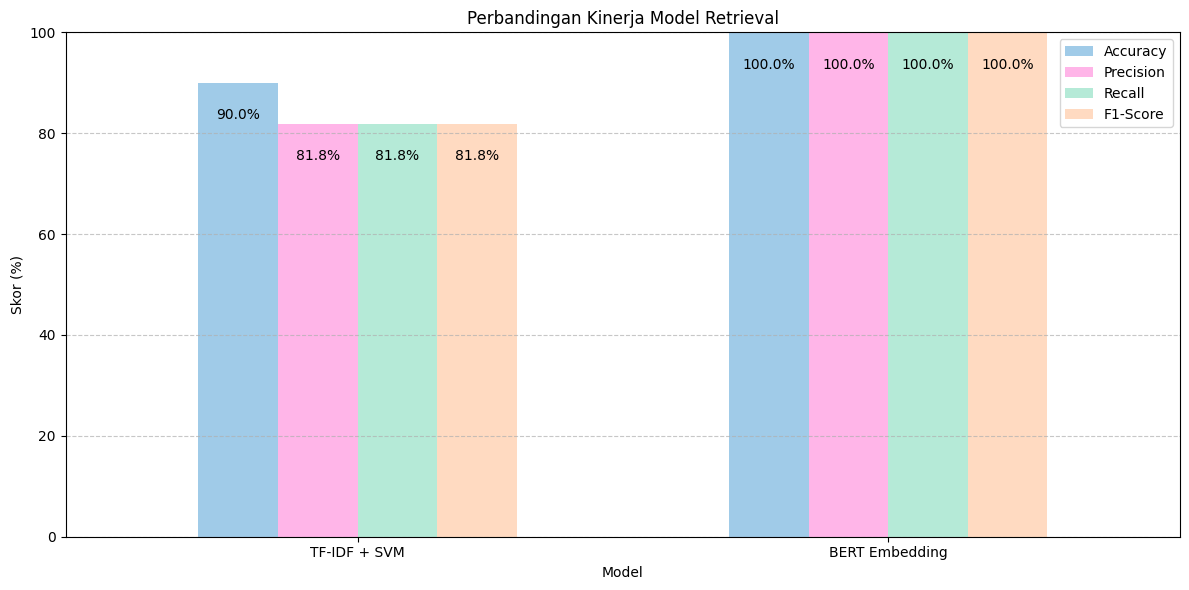

In [209]:
import matplotlib.pyplot as plt

# Buat salinan dan ubah ke persen
metrics_percent = metrics_df.copy()
metrics_percent[['Accuracy', 'Precision', 'Recall', 'F1-Score']] *= 100

# Warna pastel
pastel_colors = ['#A0CBE8', '#FFB5E8', '#B5EAD7', '#FFDAC1',
                 '#C7CEEA', '#FF9AA2', '#E2F0CB', '#FDCBBA']

# Plot diagram batang lebih renggang
ax = metrics_percent.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar',
    figsize=(12, 6),      # perbesar figure
    width=0.6,            # batang lebih ramping
    color=pastel_colors
)

# Label persentase di dalam batang
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%',
                (p.get_x() + p.get_width() / 2, height - 5 if height > 10 else height + 1),
                ha='center', va='top' if height > 10 else 'bottom',
                fontsize=10, color='black')

# Pengaturan visual
plt.title("Perbandingan Kinerja Model Retrieval")
plt.ylabel("Skor (%)")
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [213]:
import pandas as pd
from IPython.display import display

# Path ke CSV
csv_path = '/content/drive/MyDrive/Penalaran Komputer3/data/eval/prediction_metrics.csv'

# Baca CSV
df_pred = pd.read_csv(csv_path)

# Tampilkan beberapa baris awal
print("📋  data prediksi:")
display(df_pred.head(10))

# Hitung akurasi
akurasi_svm = (df_pred['status_svm'] == 'BENAR').mean() * 100
akurasi_bert = (df_pred['status_bert'] == 'BENAR').mean() * 100

print(f"\n🎯 Akurasi TF-IDF + SVM: {akurasi_svm:.2f}%")
print(f"🤖 Akurasi BERT Embedding: {akurasi_bert:.2f}%")


📋  data prediksi:


,query_id,query_text,ground_truth,pred_svm,pred_bert,status_svm,status_bert
0,1,Ini adalah isi dokumen hukum nomor 87. Terdakw...,87,87,87,BENAR,BENAR
1,2,Ini adalah isi dokumen hukum nomor 23. Terdakw...,23,23,23,BENAR,BENAR
2,3,Ini adalah isi dokumen hukum nomor 98. Terdakw...,98,98,98,BENAR,BENAR
3,4,Ini adalah isi dokumen hukum nomor 64. Terdakw...,64,64,64,BENAR,BENAR
4,5,Ini adalah isi dokumen hukum nomor 16. Terdakw...,16,16,16,BENAR,BENAR
5,6,Ini adalah isi dokumen hukum nomor 34. Terdakw...,34,34,34,BENAR,BENAR
6,7,Ini adalah isi dokumen hukum nomor 14. Terdakw...,14,14,14,BENAR,BENAR
7,8,Ini adalah isi dokumen hukum nomor 70. Terdakw...,70,70,70,BENAR,BENAR
8,9,Ini adalah isi dokumen hukum nomor 1. Terdakwa...,1,0,1,SALAH,BENAR
9,10,Ini adalah isi dokumen hukum nomor 77. Terdakw...,77,77,77,BENAR,BENAR



🎯 Akurasi TF-IDF + SVM: 90.00%
🤖 Akurasi BERT Embedding: 100.00%


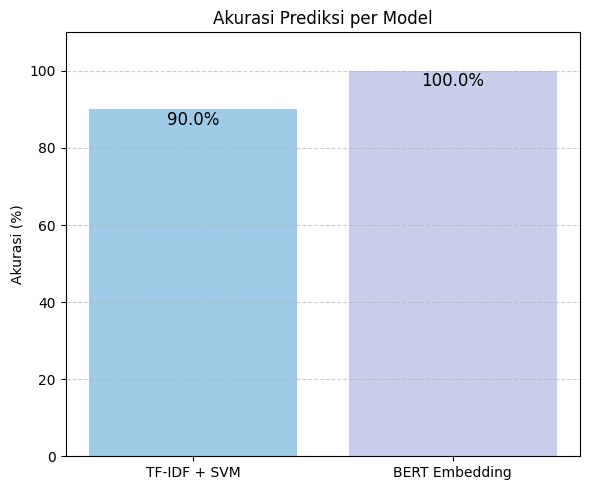

In [212]:
import matplotlib.pyplot as plt

# Data plot
models = ['TF-IDF + SVM', 'BERT Embedding']
accuracies = [akurasi_svm, akurasi_bert]
colors = ['#A0CBE8', '#C7CEEA']  # warna kalem

# Plot bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, color=colors)

# Tambahkan label angka di dalam batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 5, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12, color='black')

# Styling
plt.title("Akurasi Prediksi per Model")
plt.ylabel("Akurasi (%)")
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Diskusi Kasus Gagal Prediksi (Error Analysis)

In [210]:
# Load file prediksi per query
pred_df = pd.read_csv(f'{eval_dir}/prediction_metrics.csv')

# Tampilkan query yang SALAH diprediksi oleh SVM
print("\n Kasus Gagal – TF-IDF + SVM:")
print(pred_df[pred_df['status_svm'] == "SALAH"][['query_id', 'ground_truth', 'pred_svm']])

# Tampilkan query yang SALAH diprediksi oleh BERT
print("\n Kasus Gagal – BERT Embedding:")
print(pred_df[pred_df['status_bert'] == "SALAH"][['query_id', 'ground_truth', 'pred_bert']])


 Kasus Gagal – TF-IDF + SVM:
   query_id  ground_truth  pred_svm
8         9             1         0

 Kasus Gagal – BERT Embedding:
Empty DataFrame
Columns: [query_id, ground_truth, pred_bert]
Index: []
